In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans as kmeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import time
import warnings
import json
warnings.filterwarnings("ignore")

# Load Projected Data

In [2]:
dfname = "covertype"
ncomp = 54
X_raw = pd.read_csv("%s_raw_X.csv" % dfname, index_col=0)
X_pca = pd.read_csv("covertype_PCA_transformed_X_54_components.csv", index_col=0, header=None)
X_ica = pd.read_csv("covertype_ICA_transformed_X_54_components_sorted_by_kurtosis.csv", index_col=0, header=None)
X_rp = pd.read_csv("covertype_Randomized Projection_transformed_X_54_components.csv", index_col=0, header=None)
X_fa = pd.read_csv("covertype_Factor Analysis_transformed_X_54_components.csv", index_col=0, header=None)
Y = pd.read_csv("%s_corresponding_Y.csv" % dfname, index_col=0, header=None)

components = [1, 3] + list(range(5, 33, 4))  # list of components to iterate neural network

In [3]:
# One hot encode target values
one_hot = OneHotEncoder(categories='auto')

Y = one_hot.fit_transform(Y.values.reshape(-1, 1)).todense()

# Clustering & Neural Network Pipeline

In [4]:
class CustomGMM(GMM):
    def transform(self, x):
        return self.predict_proba(x)

In [5]:
projection = [
    ('PCA', X_pca),
    ('ICA', X_ica),
    ('RP', X_rp),
    #('FA', X_fa)
]

clustering = [
    ('No Clustering', None),
    ('kmeans', kmeans(random_state=0, n_clusters=6)),
    ('EM', CustomGMM(random_state=5, n_components=10, max_iter=50))
]

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(50), random_state=1, max_iter=300)

scoring = ['f1_macro', 'roc_auc']

In [ ]:
scores = {}

for pname, X in projection:
    scores[pname] = {}
    for cname, c in clustering:
        # initialize 
        scores[pname][cname] = {}
        for s in scoring:
            scores[pname][cname]['test_%s' %s] = []
            scores[pname][cname]['train_%s' %s] = []
            scores[pname][cname]['fit_time'] = []
        
        for n in components:        
            if c is None:
                pipe = Pipeline([('classifier', clf)])
            else:
                pipe = Pipeline([('clustering', c), ('classifier', clf)])
            score = cross_validate(pipe, X.iloc[:, :n], Y, scoring=scoring,
                         cv=3, return_train_score=True)
            for s in scoring:
                scores[pname][cname]['test_%s' %s].append(score['test_%s' %s].mean())
                scores[pname][cname]['train_%s' %s].append(score['train_%s' %s].mean())
                scores[pname][cname]['fit_time'].append(score['fit_time'].mean())
            print("--- finish neural network on %s projected data of %d components with %s clustering ---" % (pname, n, cname))

with open('%s scores_projected_clustered_dsata.json'%(dfname), 'w') as fp:
    json.dump(scores, fp)

# Plotting

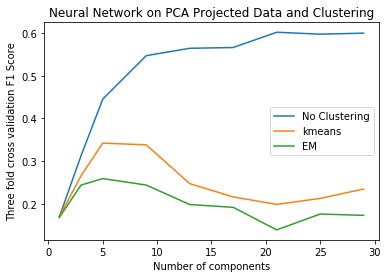

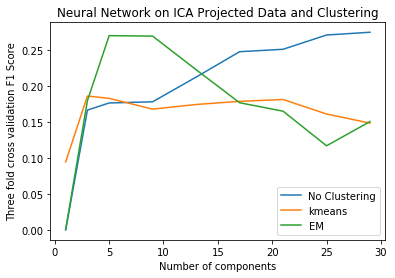

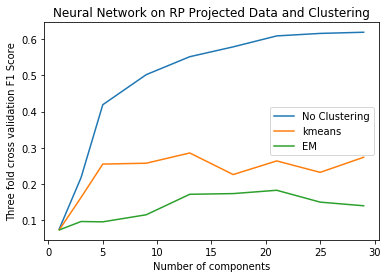

In [7]:
def plotting (scores, title, pname):
    plt.figure(figsize=(20, 20))
    fig, ax = plt.subplots()
    for cname, c in clustering:
        ax.plot(components, scores[pname][cname]['test_f1_macro'], label = cname)
    plt.xlabel("Number of components")
    plt.ylabel('Three fold cross validation F1 Score')    
    plt.title(title)
    ax.legend()

for pname, p in projection:
    plotting(scores, "Neural Network on %s Projected Data and Clustering" %(pname), pname)
plt.show()